# COVID-19


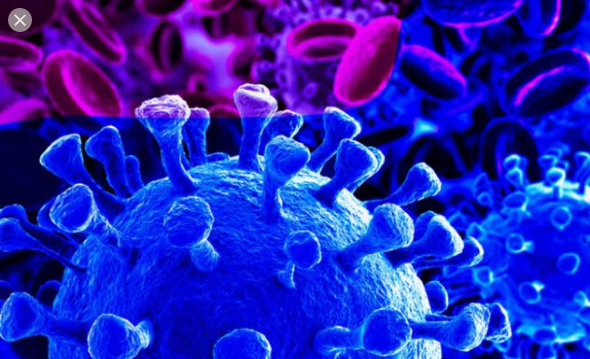

## Import libaries required for Data Exploration

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from datetime import date

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


from datetime import datetime

## Load Data from csv files into variables

In [ ]:
corona_data = pd.read_csv("../input/novel-corona-virus-2019-dataset/2019_nCoV_data.csv")
corona_confirmed = pd.read_csv("../input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv")
corona_deaths = pd.read_csv("../input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv")
corona_recovered = pd.read_csv("../input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv")

In [ ]:
# Check data
corona_data.head()

# Simple Data Cleanup Operations

* Change Date column to pandas datetime format
* Drop Sno column from data
* Set Date as index


In [ ]:
corona_data['Date'] = corona_data['Date'].apply(pd.to_datetime)
corona_data.drop(['Sno'],axis=1,inplace=True)
corona_data = corona_data.set_index('Date')

# View first few rows of the DataFrame

In [ ]:
corona_data.head()

## Sum of each cases

In [ ]:
print(f"Confirmed case: {corona_data.Confirmed.sum()}")
print(f"Deaths: {corona_data.Deaths.sum()}")
print(f"Recovered:{corona_data.Recovered.sum()}")


## World map and corona virus records in contect of world

In [ ]:
confirm = gpd.GeoDataFrame(corona_confirmed, geometry=gpd.points_from_xy(corona_confirmed.Long, corona_confirmed.Lat))
confirm.crs = {'init': 'epsg:4326'}

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

### Confirmed


In [ ]:
ax= world.plot(figsize=(20,20), color='whitesmoke', linestyle=":", edgecolor='black')
confirm.plot(markersize=10, ax=ax)

### Deaths

In [ ]:
death = gpd.GeoDataFrame(corona_deaths, geometry=gpd.points_from_xy(corona_deaths.Long, corona_deaths.Lat))
death.crs = {'init': 'epsg:4326'}
ax= world.plot(figsize=(20,30), color='whitesmoke', linestyle=":", edgecolor='black')
death.plot(markersize=10, ax=ax, color='maroon')


### Recovered

In [ ]:
recovered = gpd.GeoDataFrame(corona_recovered, geometry=gpd.points_from_xy(corona_recovered.Long, corona_recovered.Lat))
recovered.crs = {'init': 'epsg:4326'}
ax= world.plot(figsize=(20,30), color='whitesmoke', linestyle=":", edgecolor='black')
recovered.plot(markersize=10, ax=ax, color='black')

## Confirmed vs Recovered

In [ ]:
China = corona_data[corona_data.Country == 'Mainland China']
f,ax = plt.subplots(figsize=(15, 10))

sns.barplot(x="Confirmed", y="Province/State", data=China, label="Confirmed", color="r", ci=0)
sns.barplot(x="Recovered", y="Province/State", data=China, label="Recovered", color="g", ci=0)

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1500), ylabel="",xlabel="Stats")

## Daily Aggregation

In the following cell, we draw a scatter diagram for total number of cases per day.

The regression function is fit with a second order polynomial.


In [ ]:
cd = corona_data.resample('D').sum()

offset = 10000
cd['do'] = cd.index.map(lambda date: date.toordinal())

sns.set(rc={'figure.figsize':(20, 6)})

ax = sns.regplot(
    data=cd,
    x='do',
    y='Confirmed',
    label='Confirmed',
    order=2,
    scatter_kws={"s": 100}
)

sns.regplot(
    data=cd,
    x='do',
    y='Recovered',
    color='Green',
    label='Recovered',
    order=2,
    scatter_kws={"s": 100}
)

sns.regplot(
    data=cd,
    x='do',
    y='Deaths',
    color='Red',
    label='Deaths',
    order=1,
    scatter_kws={"s": 100}
)


sns.set(color_codes=True)

ax.set_xlim(cd['do'].min() - 1, cd['do'].max() + 1)
ax.set_ylim(0 - offset, cd['Confirmed'].max() + offset)

ax.legend(ncol=1, loc="upper left", frameon=True)

new_labels = [date.fromordinal(int(item)).strftime('%d-%b') for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
ax.set_ylabel('Total Confirmed Cases')
ax.set_xlabel('Date');

## Mapping Distance from Hubei Province to number of Confirmations

In the following cell, we map the relationship between Euledian Distance from the epicenter of the virus, Hubei Province in China, to the number of confirmed infections.

Note: The y-axis, confirmed cases in illustrated using a logarithmic scale.

The visualization below shows a diminishing rate of confirmed cases as we move away from Hubei. However, perhaps surprisingly there are practically no confirmed cases between 3000 to 7000 km away from the epicenter.


In [ ]:
locations = corona_confirmed.groupby('Province/State')['Lat', 'Long'].mean()

epicenter = 'Hubei'
epi_lat = locations.loc[epicenter]['Lat']
epi_long = locations.loc[epicenter]['Long']

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

def get_dist(incoming):
    return haversine(epi_lat, epi_long, incoming[0], incoming[1])

total_confirmed_by_location = corona_data.groupby(['Province/State']).sum()
locations['distance'] = locations.apply(lambda df:get_dist((df.Lat, df.Long)), axis=1)

joined_agg = total_confirmed_by_location.join(locations, how='inner')
joined_agg['log_conf'] = np.log2(joined_agg['Confirmed'])

ax_dist = sns.jointplot(x=joined_agg['distance'], y=joined_agg['log_conf'], kind='reg', color="brown", space=0)

ax_dist_kde = sns.jointplot(x=joined_agg['distance'], y=joined_agg['log_conf'], kind='kde', color="brown", space=0)
ax_dist.set_axis_labels('Distance from Hubei', ' Log of Total Confirmed Cases')
ax_dist_kde.set_axis_labels('Distance from Hubei', ' Log of Total Confirmed Cases');

## Area Plot

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
grouped = corona_data.groupby([corona_data.index.to_period('D'), 'Country']).sum()

top_8_indices = corona_data.groupby('Country').sum().sort_values(by='Confirmed', ascending=False).head(8).index
top_8_grouped = grouped.loc[grouped.index.get_level_values('Country').isin(top_8_indices)]

top_8_log_infections = np.log2(top_8_grouped.Confirmed)

unstacked = top_8_log_infections.unstack().plot(kind='area', ax=ax)
